In [2]:
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import math as math
from scipy.stats import chisquare

In [6]:
def powerlaw(r, s0, b):  
    # r0 no es variable aleatoria
    r0 = 300
    return s0*(r0/r)**(b)

def baricentro(signal,det_pos,umbral):
    sum_s = 0
    bari_x = 0
    bari_y = 0
    for i in range(len(signal)):
        if signal[i] > umbral:
            bari_x += signal[i]*det_pos[i][0]
            bari_y += signal[i]*det_pos[i][1]
            sum_s  += signal[i]            
    return(bari_x/sum_s,bari_y/sum_s)
    

#estimacion inicial del core es el baricentro

def funcion_costo2(theta,x_pos,y_pos,signal_sim,zenith,azimuth,ysigma):

        s0 = theta[0]
        b = theta[1]
        x_core = theta[2]
        y_core = theta[3]
        
        costo = np.zeros_like(s0)

        for (dist_x,dist_y,y1,sigma1) in zip(x_pos,y_pos,signal_sim,ysigma):
            
            dist = getDistances(dist_x,dist_y,x_core,y_core,zenith,azimuth)[0]
            yfit = powerlaw(dist, s0, b)
            residuo = y1 - yfit
            z = (residuo / sigma1)
            costo += z*z

        return costo
    
costo2 = lambda theta: funcion_costo2(theta,x_det,y_det,y_random1,zenith,azimuth,sigma) 

def in_hex(poli):
    path = mpltPath.Path(poli)
    hex = False
    random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    while hex != True:
        if path.contains_points([random_point]) == True:
            hex = True
        else:
            random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    return random_point

def getDistances(xpositions, ypositions, x0=0, y0=0, zenithRad=0, azimuthRad=0):

    dx = xpositions - x0    # detector wrt core positions
    dy = ypositions - y0
    
    groundDistances = np.sqrt(dx*dx+dy*dy)

    # Direction cosines in the plane xy
    dirx =  math.cos(azimuthRad)
    diry =  math.sin(azimuthRad)

    axisProjections = math.sin(zenithRad) * (dx*dirx+dy*diry)
    
    distances = np.sqrt( groundDistances**2 - axisProjections**2 )
    
    return (distances,axisProjections,groundDistances)

def simZenith(zenithMinDeg, zenithMaxDeg) :

    zenithMinRad = math.radians(zenithMinDeg)
    sin2MinZenith = math.sin(zenithMinRad)**2

    zenithMaxRad = math.radians(zenithMaxDeg)
    sin2MaxZenith = math.sin(zenithMaxRad)**2

    rng = np.random.default_rng()
    u = rng.random() 
    
    sin2Zenith = sin2MinZenith + u * (sin2MaxZenith-sin2MinZenith)
    sinZenith = math.sqrt(sin2Zenith) 

    zenith = math.asin(sinZenith)
    azimut = np.random.uniform(0,2*np.pi)
    
    return (zenith,azimut)

poligono = [[-216.5,-375],[216.5,-375],[433,0],[216.5,375],[-216.5,375],[-433,0]]
detectores_pos = [[-216.5,-375],[216.5,-375],[433,0],[216.5,375],[-216.5,375],[-433,0],[0,0]]
rectangulo = [[-433,-375],[433,-433],[433,375],[-433,375]]
pointsx,pointsy = [-216.5,216.5,433,216.5,-216.5,-433.5,0] , [-375,-375,0,375,375,0,0]
centro = (0,0)
x_det = np.zeros(len(detectores_pos))
y_det = np.zeros(len(detectores_pos))
for i in range(len(detectores_pos)):
    x_det[i] = detectores_pos[i][0]
    y_det[i] = detectores_pos[i][1]

In [4]:
#Defino parametros de LDF 
r0 = 300 #metros 
s0 = 35 #VEM
angulo = 0
zenith = simZenith(-angulo,angulo)[0]
azimuth = simZenith(-angulo,angulo)[1]
b = 2.1    

#Genero el punto random
random_point = in_hex(poligono)

#calculo las distancias entre el evento y los 7 detectores.
distancias = getDistances(np.asarray(pointsx),np.asarray(pointsy),random_point[0],random_point[1],simZenith(-angulo,angulo)[0],simZenith(-angulo,angulo)[1])
r = np.asarray(distancias[0])

signal = powerlaw(r,s0,b)
sigma_signal = np.sqrt(signal)

#Hago el ajuste y defino la semilla inicial
y_random = np.random.normal(signal,sigma_signal,size = len(signal)) #signal
y_random = y_random[y_random > 2]
sigma = np.sqrt(y_random)

core_est_x = baricentro(y_random,detectores_pos)[0] 
core_est_y = baricentro(y_random,detectores_pos)[1] 

TypeError: baricentro() missing 1 required positional argument: 'umbral'

In [ ]:
res = minimize(costo2, x0=(30,1,core_est_x,core_est_y))
#print(res)
print('Minimize results')
print("Parametros ajustados: ", res.x)
cova = 2*res.hess_inv
par_error = np.sqrt(np.diagonal(cova))
print('Errores de los parámetros', par_error)
print(cova)

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(pointsx,pointsy)
plt.scatter(core_est_x,core_est_y,c='orange')
plt.scatter(random_point[0],random_point[1],s = 90,c='green')
plt.scatter(res.x[2],res.x[3],s = 90,c='red')
plt.grid()


In [149]:
tries = 5000
Figura = False

r0 = 300 #metros 
s0 = 100 #VEM
angulo = 0
zenith = simZenith(-angulo,angulo)[0]
azimuth = simZenith(-angulo,angulo)[1]
b = 2.1  

#Core de la lluvia estimado
pos_res_x = []
pos_res_y = []

#Core de la lluvia estimado para las minimizaciones fallidas
pos_res_x_f = []
pos_res_y_f = []

#Core de la lluvia simulado
puntos_x = []
puntos_y = []

signals = []

Falso = 0
Verd = 0

#Baricentro de los distintos eventos 
bar_x = []
bar_y = []
#Baricentro de los distintos eventos fallidos
bar_x_f = []
bar_y_f = []

#Me guardo la distancia entre el core simulado y el estimado
dist_core_sim = []

resultados_f = []
resultados_t = []

umbral = 2

for i in range(tries):
    
    #Genero el core de impacto de la lluvia
    random_point = in_hex(poligono)

    
    #calculo las distancias entre el evento y los 7 detectores.
    distancias = getDistances(np.asarray(pointsx),np.asarray(pointsy),random_point[0],random_point[1],simZenith(-angulo,angulo)[0],simZenith(-angulo,angulo)[1])
    r = np.asarray(distancias[0])
    
    #Evalulo la señal 
    signal = powerlaw(r,s0,b)
    sigma_signal = np.sqrt(signal)

    #Randomizo la señal 
    y_random = np.random.normal(signal,sigma_signal,size = len(signal)) #señal simulada
    
    #Impongo filtro 
    y_random1 = y_random[y_random > umbral]
    sigma = np.sqrt(y_random1)
    
    #Defino el baricentro para usarlo como la semilla inicial  
    seed_x = baricentro(y_random,detectores_pos,umbral)[0] 
    seed_y = baricentro(y_random,detectores_pos,umbral)[1]
    
    #Inicio la minimizacion 
    res = minimize(costo2,x0=(30,1,seed_x,seed_y),tol = 1e-4)
    
    #Si la minimizacion fue exitosa...
    if res.success == True:
        
        #Distancia entre core estimado y core simulado
        dist_core_sim.append(np.sqrt((res.x[2] - random_point[0])**2 + (res.x[3] - random_point[1])**2))

        #Me guardo el resultado de los distintos cores estimados
        pos_res_x.append(res.x[2])
        pos_res_y.append(res.x[3])
        
        Verd += 1
        
        bar_x.append(seed_x)
        bar_y.append(seed_y)
        
        #Me guardo los cores simulados 
        puntos_x.append(random_point[0])
        puntos_y.append(random_point[1])
        
        #Me guardo las señales filtradas
        signals.append(y_random)
        
        #Me guardo el resultado de la simulacion
        resultados_t.append(res)
    
    #Si la minimizacion fue exitosa...
    if res.success == False:
        #Me guardo el resultado de la simulacion
        resultados_f.append(res)
        
        Falso += 1 
        
        #Me guardo los cores estimados para cuando la minimizacion falla
        pos_res_x_f.append(res.x[2])
        pos_res_y_f.append(res.x[3])
        
        #Me guardo los baricentros de las minimizaciones fallidas
        bar_x_f.append(seed_x)
        bar_y_f.append(seed_y)
        
        if Figura == True:
            plt.figure(figsize=(8,8))
            plt.scatter(pointsx,pointsy)
            plt.scatter(seed_x,seed_y)
            plt.scatter(random_point[0],random_point[1],s=90,c='green')
            plt.scatter(res.x[2],res.x[3],s=90,c='red')
            plt.text(x=seed_x, y=seed_y, s='Baricentro',size = 15)
            plt.text(x=res.x[2],y=res.x[3], s='Core estimado',size = 15)
            plt.text(x=random_point[0], y=random_point[1], s='Core simulado',size = 15)
            plt.grid()
            break
        

        

<ipython-input-6-e757db466ba7>:35: RuntimeWarning: overflow encountered in double_scalars
  costo += z*z
/Users/gunitettamanti/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in subtract
  df = (f(*((xk + d,) + args)) - f0) / d[k]
<ipython-input-6-e757db466ba7>:35: RuntimeWarning: overflow encountered in double_scalars
  costo += z*z


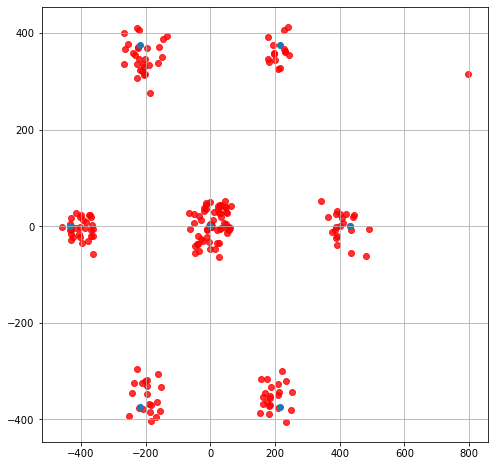

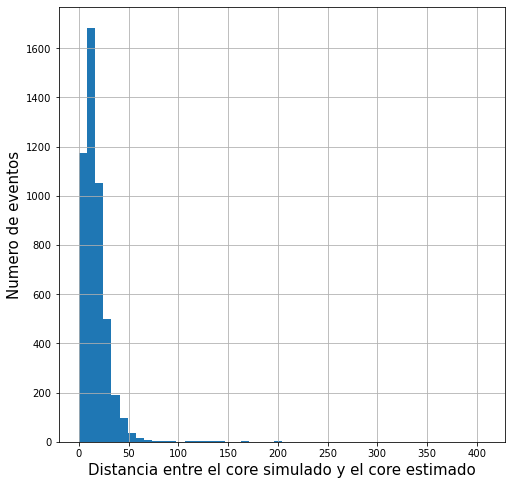

In [160]:
plt.figure(figsize=(8,8))
#plt.scatter(pos_res_x,pos_res_y,c='blue',alpha = 0.8)
plt.scatter(pos_res_x_f,pos_res_y_f,c='red',alpha = 0.8)
#plt.scatter(puntos_x,puntos_y,alpha = 0.2)
#plt.scatter(bar_x_f,bar_y_f,c='orange',alpha = 0.8)
plt.scatter(pointsx,pointsy)
#plt.xlim(-500,500)
#plt.ylim(-500,500)
plt.grid()

plt.figure(figsize=(8,8))
plt.xlabel('Distancia entre el core simulado y el core estimado',size=15)
plt.ylabel('Numero de eventos',size=15)
plt.hist(dist_core_sim,bins=50)
plt.grid()
#plt.xlim(0,1500)
#plt.ylim(0,2000)
plt.show()

In [154]:
(Falso/(Verd+Falso))

0.0426

In [157]:
maximo = np.where(dist_core_sim == np.max(dist_core_sim))

In [158]:
resultados_t[maximo[0][0]]

      fun: 46.0209733727104
 hess_inv: array([[ 9.75826822e+01,  1.32774859e+00,  6.32907746e+01,
        -1.17772257e+02],
       [ 1.32774859e+00,  2.60777839e-02, -2.57341949e-01,
        -2.03766220e+00],
       [ 6.32907746e+01, -2.57341949e-01,  5.99148772e+02,
        -3.46735115e+01],
       [-1.17772257e+02, -2.03766220e+00, -3.46735115e+01,
         1.67052477e+02]])
      jac: array([ 0.00000000e+00,  4.52995300e-05, -9.53674316e-07, -4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 636
      nit: 76
     njev: 106
   status: 0
  success: True
        x: array([ 88.47587641,   1.34253321, 431.0403712 , -41.14254652])

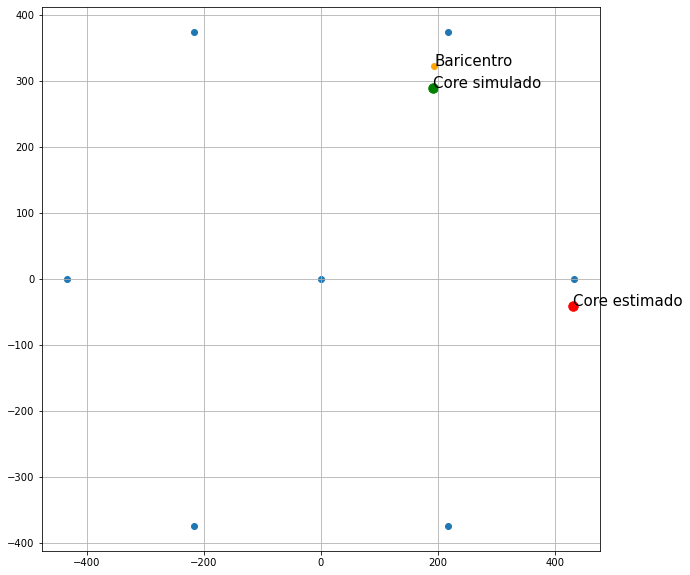

In [159]:
plt.figure(figsize=(10,10))
plt.scatter(pointsx,pointsy)
plt.scatter(bar_x[maximo[0][0]],bar_y[maximo[0][0]],c='orange')
plt.scatter(puntos_x[maximo[0][0]],puntos_y[maximo[0][0]],s = 90,c='green')
plt.scatter(resultados_t[maximo[0][0]].x[2],resultados_t[maximo[0][0]].x[3],s = 90,c='red')
plt.text(x=bar_x[maximo[0][0]], y=bar_y[maximo[0][0]], s='Baricentro',size = 15)
plt.text(x=resultados_t[maximo[0][0]].x[2], y=resultados_t[maximo[0][0]].x[3], s='Core estimado',size = 15)
plt.text(x=puntos_x[maximo[0][0]], y=puntos_y[maximo[0][0]], s='Core simulado',size = 15)
plt.grid()


In [137]:
signals[maximo[0][0]]

array([ 3.15486534, 16.2778047 , 75.31692323, 56.45061372,  8.82660799,
        4.49383232, 17.53816207])